In [1]:
import torch
import torch.nn as nn
import torch.optim as optim # parameters optimisation

from torchvision import datasets, transforms # CV packages
from torch.utils.data import DataLoader # data loader

import matplotlib.pyplot as plt

In [2]:
# torch.manual_seed(21)

In [3]:
# check availability of GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [4]:
# Pro-processing
transform = transforms.Compose([
    transforms.ToTensor(), # convert image to tensor
    # 标准化 (MNIST dataset 是灰度图像，只需要有一个通道)
    # 缩放像素值
    transforms.Normalize((0.5,), (0.5,))
    # 彩度图像 => Normalize((0.5, 0.5, 0.5), (0.5,))
])

data_path = '/tmp/data/mnist'

# Load MNIST dataset
train_dataset = datasets.MNIST(data_path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Load data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
# 3-layer neural network
class o1Net(nn.Module):
    def __init__(self):
        super().__init__()
        # define fully connected layers
        # 1 input layer (28*28)
        # 3 hidden layers (256, 128, 64)
        # 1 output layer (10)
        self.fcl1 = nn.Linear(28*28, 256) # (input, output)
        self.fcl2 = nn.Linear(256, 128) 
        self.fcl3 = nn.Linear(128, 64)
        self.fcl4 = nn.Linear(64, 10) # output => classification
    
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1) # flatten, to conduct fully connected
        x = torch.relu(self.fcl1(x)) # after pass 1st flc (28*28 => 256, feature extracted)
                                     # ReLU, add some non-linear features (acitvation function)
        x = torch.relu(self.fcl2(x))
        x = torch.relu(self.fcl3(x))
        x = self.fcl4(x) # output layer, no activation function need
        
        # nn.CrossEntropyLoss will be conducted softmax function inner
        # no need to add a softmax function
        # x = torch.softmax(x, dim=1) # softmax, output probability

        return x # the largest probability value

In [6]:
# Model initialisation
model = o1Net().to(device)

In [7]:
# Define the loss function and optimiser
criterion = nn.CrossEntropyLoss() # loss function
optimiser = optim.Adam(model.parameters(), lr=0.001) # Adam optimiser (学习率 0.001)

# Save loss and accuracy
train_losses = []
train_accuracies = []
test_accuracies = []

In [8]:
# Training model
epochs = 10 # 训练轮次
best_accuracy = 0.0 # record the best accuracy
best_model_path = 'best_mnist_model.pth' # save the best model path

for epoch in range(epochs):
    running_loss = 0.0 # set inital loss to be 0
    correct_train = 0 # correct prediction
    total_train = 0 # total prediction / sample number

    # Training process
    model.train() # set model to training mode
    for inputs, labels in train_loader: # read data from training data set
        inputs, labels = inputs.to(device), labels.to(device) # move data to device (CPU here)

        optimiser.zero_grad() # clear the gradient

        outputs = model(inputs) # forward pass
        
        loss = criterion(outputs, labels) # calculate loss (交叉损失函数)
        loss.backward() # backpropagation (反向传播) of loss (to get the lowest loss)
        
        optimiser.step() # update the weights

        running_loss += loss.item() # 累加损失 (之后求平均, 获得每个epoch的平均损失)

        # Calculate accuracy in the traning dataset
        _, predicted = torch.max(outputs, 1) # get the predicted value
        total_train += labels.size(0) # sample number
        correct_train += (predicted == labels).sum().item() # correct prediction

    # Calculate accuracy in the training set
    train_accuracy = correct_train/total_train
    train_losses.append(running_loss/len(train_loader)) # record each epochs's average loss
                                                        # len(train_loader) => batch number
    train_accuracies.append(train_accuracy) # record each epochs's accuracy
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2%}")

    # Evaluation model in test dataset
    model.eval() # set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad(): # without gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) # forward pass
            _, predicted = torch.max(outputs, 1) # prediction result
            total += labels.size(0) # total sample number
            correct += (predicted == labels).sum().item() # accumulate correct prediction

    # calculate accuracy in testing dataset
    test_accuracy = correct/total
    test_accuracies.append(test_accuracy) # record each epochs' testing accuracy
    print(f"Epoch {epoch+1}/{epochs}, Testing Accuracy: {test_accuracy:.2%}")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), best_model_path) # save the best model
        print(f"Best model saved with accuracy: {best_accuracy:.2%}")

Epoch 1/10, Training Loss: 0.3575, Training Accuracy: 88.93%
Epoch 1/10, Testing Accuracy: 93.43%
Best model saved with accuracy: 93.43%
Epoch 2/10, Training Loss: 0.1582, Training Accuracy: 95.09%
Epoch 2/10, Testing Accuracy: 95.97%
Best model saved with accuracy: 95.97%
Epoch 3/10, Training Loss: 0.1187, Training Accuracy: 96.30%
Epoch 3/10, Testing Accuracy: 96.48%
Best model saved with accuracy: 96.48%
Epoch 4/10, Training Loss: 0.0982, Training Accuracy: 96.88%
Epoch 4/10, Testing Accuracy: 97.41%
Best model saved with accuracy: 97.41%
Epoch 5/10, Training Loss: 0.0821, Training Accuracy: 97.32%
Epoch 5/10, Testing Accuracy: 96.52%
Epoch 6/10, Training Loss: 0.0737, Training Accuracy: 97.60%
Epoch 6/10, Testing Accuracy: 97.16%
Epoch 7/10, Training Loss: 0.0623, Training Accuracy: 98.00%
Epoch 7/10, Testing Accuracy: 97.35%
Epoch 8/10, Training Loss: 0.0574, Training Accuracy: 98.16%
Epoch 8/10, Testing Accuracy: 97.27%
Epoch 9/10, Training Loss: 0.0511, Training Accuracy: 98.28%

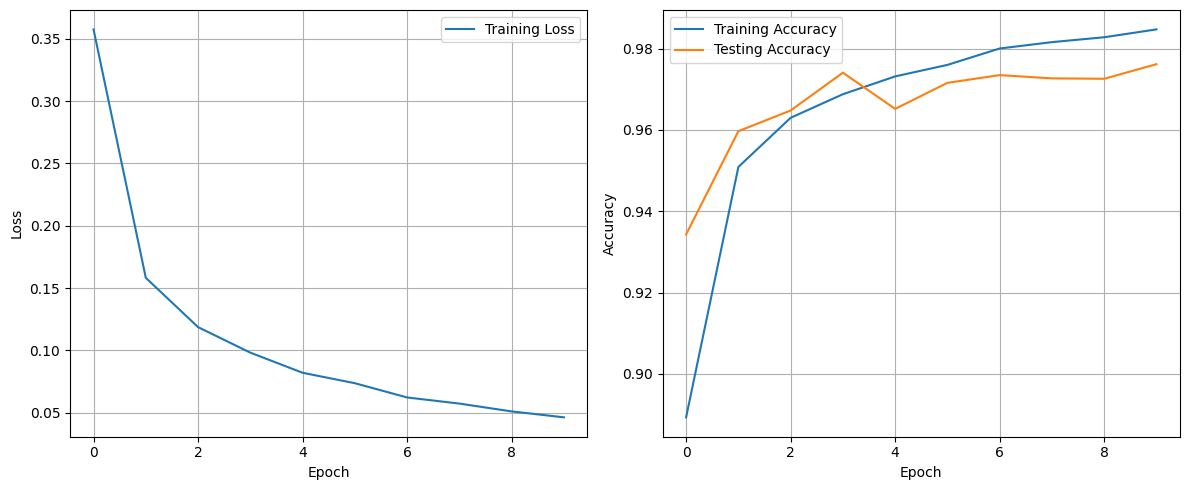

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mnist_curves.png')
plt.show()